In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 42
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

Running on CPU


2024-01-31 20:14:19.724194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-2.1.3/installation/lib:/share/jdk-16.0.1/lib::
2024-01-31 20:14:19.724241: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-31 20:14:19.724267: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c2-1): /proc/driver/nvidia/version does not exist
2024-01-31 20:14:19.724711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural N

In [2]:
### Sverdrup 
mainDir_r4  = '/scratch2/pillarh/eccov4r4'
mainDir_r5  = '/scratch2/pillarh/eccov4r5'
gridDir  = mainDir_r4 + '/GRID'
dataDir  = mainDir_r5 + '/V4r5/diags_daily'
thetaDir = mainDir_r5 + '/V4r5/diags_daily/SST_day_mean'
thetaDir_ext = mainDir_r5 + '/V4r5_ext_2020_2023_Jun/diags_daily/SST_day_mean'

In [3]:
# SSH has to be kept because someone used the SSH metadata for SST, 
# It's not a bug in this code but a hack to handle an existing bug.
ds = xmitgcm.open_mdsdataset(data_dir = thetaDir,
                             grid_dir = gridDir,
                             extra_variables = dict(SSH = dict(dims=['k','j','i'],
                                                               attrs = dict(standard_name="SST",
                                                                            long_name="Sea Surface Temperature",
                                                                            units="degC"))))
ds["SST"] = ds["SSH"]
ds = ds.drop(["SSH"])
    
ds_ext = xmitgcm.open_mdsdataset(data_dir = thetaDir_ext,
                                 grid_dir = gridDir,
                                 extra_variables = dict(SST = dict(dims=['k','j','i'],
                                                                   attrs = dict(standard_name="SST",
                                                                                long_name="Sea Surface Temperature",
                                                                                units="degC"))))

ds = xr.concat([ds, ds_ext], "time")
ds_r4 = xr.open_dataset(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')

llc_compact_to_faces: dims, llc  (1000, 1170, 90) 90
llc_compact_to_faces: data_compact array type  float32
llc_faces_to_tiles: data_tiles shape  (1000, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  float32


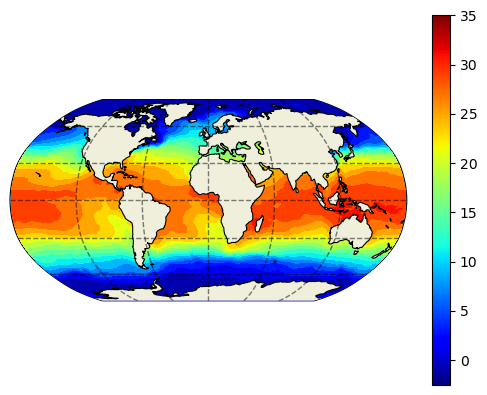

In [7]:
SST = ds['SST'].data
SST_t = ecco.llc_compact_to_tiles(SST[:1000])


P = ecco.plot_proj_to_latlon_grid(ds_r4['XC'], ds_r4['YC'],
                                    np.asarray(SST_t[0]),
                                    plot_type = 'contourf',
                                    show_colorbar = True,
                                    cmap = 'jet', cmax = 35,
                                    dx=2, dy=2, projection_type = 'robin',
                                    less_output = True, subplot_grid = [1,1,1])